# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Multi-parameter sensitivity

The HFM library provides a variety of metric classes : isotropic, Riemannian, Rander, asymmetric quadratic, defined by a Hooke tensor, and more. With the exception of isotropic metrics they depend on multiple parameters.

Automatic differentiation is more complex with anisotropic metrics, and requires specific computational techniques, for which we can only provide limited support. We illustrate here their foundations and usage.
For that purpose, we distinguish cases depending on an implementation detail that is usually transparent to the user.

**Eulerian vs Semi-Lagrangian schemes.**
The HFM (Hamiltonian Fast Marching) library takes its name from a family of Eulerian schemes based on a specific representation of the Hamiltonian, which are particularly efficient for Riemannian metrics and curvature penalized metrics, see:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

However, other classes of metrics (such as Rander, asymmetric quadratic, or hooke tensor defined), require a different approach. In their case, we rely on an adaptive semi-Lagrangian scheme, in the spirit of 
* Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Forward differentiation of semi-Lagrangian schemes](#1.-Forward-differentiation-of-semi-Lagrangian-schemes)
    * [5.2 Semi-Lagrangian - backward](#5.2-Semi-Lagrangian---backward)
    * [5.2 Eulerian schemes](#5.2-Eulerian-schemes)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [8]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SensitivityMultiple','FMM'))

In [131]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Metrics
from agd import LinearParallel as lp
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Sensitivity'

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize

In [136]:
def reload_packages():
    from importlib import reload
    HFMUtils = reload(sys.modules['agd.HFMUtils'])
    HFMUtils.reload_submodules()
    fd = reload(sys.modules['agd.FiniteDifferences'])
    Metrics = reload(sys.modules['agd.Metrics'])
    Metrics.reload_submodules()
    ad = reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()
    lp = reload(sys.modules['agd.LinearParallel'])

## 1. Forward differentiation of semi-Lagrangian schemes

**Semi-Lagrangian schemes.** Those are discretizations of the eikonal equation 
$$
    F_x^*(\nabla u(x)) = 1
$$
in the following form which is closely related with Bellman's optimality principle
$$
    u(x) = \min_{y \in S(x)} F_x(x-y) + I_{S(x)} u(y),
$$
where $S(x)$ the *stencil* is a polygonal neighborhood of $x$ whose vertices are grid-points, and $I_S$ denotes piecewise linear interpolation.
The equality is imposed at all points of the discrete or continuous domain. In addition, adequate boundary conditions are imposed on the domain boundary, usually of Dirichlet and of outflow type.

**The geodesic flow.**
The minimizer $y_*(x) \in S(x)$ in the semi-lagrangian discretization of the eikonal equation has a geometrical interpretation: $v_*(x) = x-y_*(x)$ approximates the direction of the minimal geodesic passing through $x$, referred to as the geodesic flow direction. This data it is optionally exported by the HFM library, after normalization, under the name `geodesicFlow`.

<!---
Said otherwise, one has $V(x) \approx v_*$, where 
$$
    \gamma'(t) = V(\gamma(t)) \quad V(x) = \nabla F_x^*(\nabla u(x))
$$
--->

**The envelope theorem.**
Under suitable assumptions, one can differentiate the value of an optimization problem w.r.t. parameters, using the so-called envelope theorem: the extremizer variation can be ignored at first order.

Said otherwise, if the metric depends on a small parameter $\epsilon$, then
$$
    u(x;\epsilon) = F_x(v_*(x);\epsilon) + I_{S(x)}u(y_*(x);\epsilon) + o(\epsilon).
$$

As a result, if two parameter dependent metrics $F$ and $G$ obey
$$
    F_x(v_*(x); \epsilon) = G_x(v_*(x); \epsilon) + o(\epsilon),
$$
at all discretization points $x$, then they produce identical first order perturbations of $u$.
The HFM library takes advantage of this fact to simplify computations, but for that purposes needs the geodesic flow direction $v_*(x)$ to be computed in a preliminary step.

### 1.1 Isotropic example

We use a Rander metric to encode an isotropic metric, so as to illustrate the semi-Lagrangian discretization.

In [97]:
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'arrayOrdering':'RowMajor',
    'seeds':[[0,0]],
    'extractValues':True,
})
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=100)
X = np.array(hfmIn.Grid())

delta = ad.Dense.identity((1,))
metric =  Metrics.Rander.from_cast(Metrics.Isotropic(1.+delta[0],vdim=2))

As described above, automatic differentiation in the semi-Lagrangian setting is a two-step process.

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.008236 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


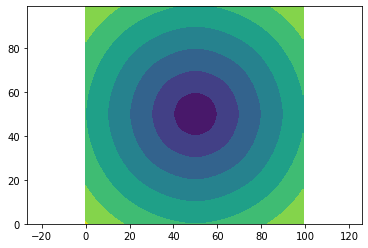

In [98]:
hfmIn['metric'] = metric
hfmOut_ad,values_ad = hfmIn.RunSmart()
plt.axis('equal')
plt.contourf(*X,values_ad.gradient(0)); 

The caching of the geodesicflow could be done manually.

--- First run for caching geodesic flow information ---
Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.008721 s.
Filling cache data
--- Second run using cached data :  dict_keys(['values', 'activeNeighs', 'geodesicFlow'])  ---
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


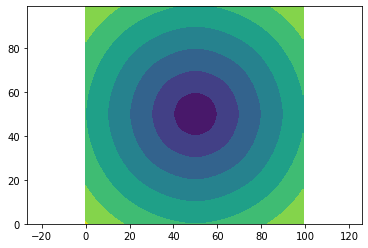

In [99]:
print("--- First run for caching geodesic flow information ---")
hfmIn_noad = hfmIn.copy()
hfmIn_noad['metric'] = ad.remove_ad(metric,iterables=(Metrics.Base,))
cache = HFMUtils.Cache(needsflow=True)
hfmIn_noad.RunSmart(cache=cache)

print("--- Second run using cached data : ", cache.contents.keys()," ---")
hfmOut_ad,values_ad = hfmIn.RunSmart(cache=cache)
plt.axis('equal')
plt.contourf(*X,values_ad.gradient(0));

## 1.1 Anisotropic example

In [118]:
np.expand_dims(np.eye(2),-1).shape
np.eye(2)[...,None,None].shape

(2, 2, 1, 1)

In [139]:
reload_packages()
a = ad.Dense.denseAD(np.random.rand(2,2),np.random.rand(2,2,3))
b = lp.inverse(a)
lp.dot_AA(a,b)

denseAD(array([[1., 0.],
       [0., 1.]]),
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.44089210e-16, -5.55111512e-17,  0.00000000e+00]],

       [[ 0.00000000e+00, -5.55111512e-17, -5.55111512e-17],
        [ 0.00000000e+00, -1.38777878e-17, -2.77555756e-17]]]))

In [146]:
reload_packages()
a = ad.Dense2.denseAD2(np.random.rand(2,2),np.random.rand(2,2,3),np.random.rand(2,2,3,3))

#b = a._linalg_inv()
b = lp.inverse(a)
lp.dot_AA(a,b)

denseAD2(array([[1.00000000e+00, 0.00000000e+00],
       [4.75964754e-17, 1.00000000e+00]]),
array([[[-1.11022302e-16, -4.44089210e-16,  0.00000000e+00],
        [ 0.00000000e+00,  2.22044605e-16,  2.22044605e-16]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]),
array([[[[-2.22044605e-16, -4.44089210e-16,  1.33226763e-15],
         [-4.44089210e-16, -1.77635684e-15, -4.44089210e-16],
         [ 8.88178420e-16, -4.44089210e-16,  4.44089210e-16]],

        [[ 8.88178420e-16, -8.88178420e-16,  4.44089210e-16],
         [-4.44089210e-16,  3.33066907e-16,  3.33066907e-16],
         [ 4.44089210e-16, -2.77555756e-17,  4.44089210e-16]]],


       [[[-2.22044605e-16, -4.44089210e-16,  4.44089210e-16],
         [ 0.00000000e+00, -1.77635684e-15,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 4.44089210e-16,  0.00000000e+00,  8.88178420e-16],
         [-4.44089210e-16,  0.

In [158]:
reload_packages()
a = ad.Sparse.identity(constant=np.random.rand(2,2))
b = lp.inverse(a)
ident=lp.dot_AA(a,b)
ident.simplify_ad()
ident

<class 'agd.AutomaticDifferentiation.Sparse.spAD'>
<class 'agd.AutomaticDifferentiation.Dense.denseAD'>
<class 'numpy.ndarray'>


spAD(array([[ 1.00000000e+00, -1.11022302e-16],
       [ 0.00000000e+00,  1.00000000e+00]]), array([[[ 5.55111512e-17,  0.00000000e+00,  0.00000000e+00,
          2.22044605e-16],
        [ 0.00000000e+00,  2.22044605e-16,  2.22044605e-16,
          0.00000000e+00]],

       [[ 0.00000000e+00,  1.11022302e-16, -1.38777878e-17,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  5.55111512e-17,
          1.66533454e-16]]]), array([[[0, 1, 2, 3],
        [0, 1, 2, 3]],

       [[0, 1, 2, 3],
        [0, 1, 2, 3]]]))

In [ ]:
We reproduce a 

In [105]:
R = np.linalg.norm(X,axis=0)
driftMult = 0.9*np.sin(2*np.pi*X[0])*np.sin(2.*np.pi*X[1])
drift = (driftMult/R) * X
metric = Metrics.Rander.from_Zermelo(np.eye(2),drift)

In [114]:
#generate two independent symbolic perturbations
delta = ad.Dense.identity(shape=(2,))
drift_ad = ad.Dense.denseAD(drift)
drift_ad[0] += delta[0]*(X[1]>0) 
drift_ad[1] += delta[1]*(X[1]>0)

metric = Metrics.Rander.from_Zermelo(np.eye(2),drift_ad)

AssertionError: 

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.012422 s.
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


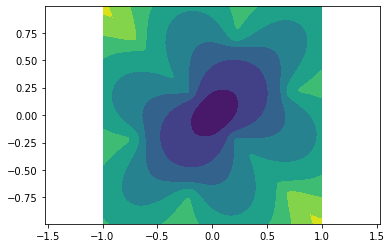

In [113]:
hfmIn['metric']=metric
hfmOut,values = hfmIn.RunSmart()
plt.axis('equal')
plt.contourf(*X,values)

In [ ]:
plt.contourf(*X,values)

In [103]:
hfmOut

({'FMCPUTime': 0.014403,
  'GeodesicCPUTime': 3e-06,
  'MaxStencilWidth': 4.0,
  'StencilCPUTime': 0.010439,
  'defaulted': 'cosAngleMin exportActiveNeighs exportGeodesicFlow factoringMethod order refineStencilAtWallBoundary showProgress spreadSeeds verbosity',
  'nAccepted': 10000.0,
  'unusedFromCompute': 'FMCPUTime GeodesicCPUTime MaxStencilWidth StencilCPUTime nAccepted values',
  'visitedUnset': 'activeNeighs costVariation dualMetric euclideanScale getStencils gridScales indexToPoint inspectSensitivity nMaxAccepted pointToIndex progressReportLandmarks seedFlags seedValueVariation seedValues stencilGeometry stopAtDistance stopWhenAllAccepted stopWhenAnyAccepted tips values walls',
  'retcode': 0},
 array([[1.02597835, 1.01337662, 1.00278461, ..., 1.22263854, 1.24221306,
         1.23678411],
        [1.01337662, 0.99808838, 0.98645912, ..., 1.22942555, 1.22278261,
         1.21658114],
        [1.00278461, 0.98645912, 0.97287877, ..., 1.21192568, 1.2027602 ,
         1.19597318],
 

## 2. Reverse differentiation of semi-Lagrangian schemes

In [129]:
cost = np.ones(hfmIn['dims'].astype(int))
rev,cost_ad = ad.Reverse.empty(inputs=cost,input_iterables = (dict,Metrics.Base))
metric_ad =  Metrics.Rander.from_cast(Metrics.Isotropic(cost_ad))
hfmIn['metric'] = metric_ad
hfmIn['extractValues']=True

In [131]:
hfmOut,values_ad = rev.apply(HFMUtils.RunSmart,hfmIn,cache=HFMUtils.Cache(needsflow=True))

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.008538 s.
Filling cache data


In [133]:
rev.gradient(values_ad[0,0])

Providing cached data
Returned with exit code  -15


NameError: name 'Metric' is not defined

### 5.2 Eulerian schemes

In this experiment, we consider a metric depending on two cost functions, and perform sensitivity analysis w.r.t. each both. More precisely, we use the two dimensional diagonal metric model, which lets the user choose different costs of motion along the $x$ and $y$ axes.

This model admits a differentiable variant, similarly to the isotropic case, although it is not implemented at the time of writing.

In [41]:
hfmInput2={}
hfmInput2['model']='Diagonal2'

In [42]:
# Possibly distinct cost, and scale, in the x and y directions
cost = hfmInput['cost']; gridScale= hfmInput['gridScale'];
hfmInput2['cost'] = np.stack((cost, cost),axis=2)
hfmInput2['gridScales'] = [gridScale, gridScale]

for key in ['walls','dims','seeds','tips','seedValues','arrayOrdering','exportValues','origin','inspectSensitivity']:
    hfmInput2[key]=hfmInput[key]

In [43]:
hfmOutput = HFMUtils.Run(hfmInput) # Isotropic model
print("---")
hfmOutput2 = HFMUtils.Run(hfmInput2) # Diagonal model

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.006233 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0

---
Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.006236 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0



In order to make a consistency check, the diagonal matrix was set up to reproduce exactly the isotropic cost, by choosing identical diagonal coefficients.

In [44]:
# Arrival time values are equal by construction of the test cases
walls,values,values2 = hfmInput['walls'],hfmOutput['values'].copy(),hfmOutput2['values'].copy()
values[walls]=0; values2[walls]=0; # Values equal inf on the walls.
np.max(np.abs(values-values2))

0.0

We first discuss backward differentiation. As can be observed, the sensitivity of the arrival time w.r.t. variations of the cost associated with the x and y directions are now returned separately.

In [45]:
sensitivity2 = hfmOutput2['costSensitivity_0'] # Sensitivity of the arrival time at the first point

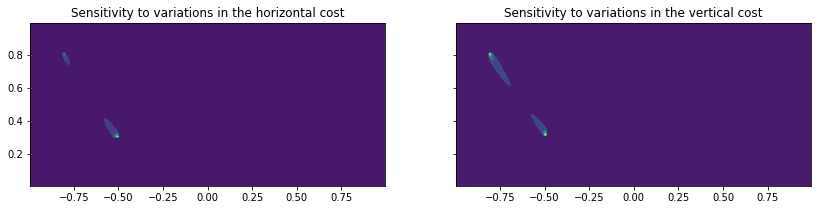

In [46]:
_, (ax0,ax1) = plt.subplots(1,2,sharey=True,figsize=(14,3));

# Display sensitivity w.r.t variations of the first component of the cost, relative to the x direction
ax0.set_title('Sensitivity to variations in the horizontal cost')
ax0.contourf(X,Y,sensitivity2[:,:,0]) 
ax1.set_title('Sensitivity to variations in the vertical cost')
ax1.contourf(X,Y,sensitivity2[:,:,1]);

Consistency check with the isotropic case. Since we choose a diagonal model with equal costs along the two axes, we fall back to the sensitivity of the isotropic model by adding the two sensitivities of the diagonal model.

In [47]:
np.max(np.abs(sensitivity2.sum(axis=2)-hfmOutput['costSensitivity_0']))

8.673617379884035e-19

We next turn to forward differentiation. We may specify distinct variations for the two components of the cost, here associated with the and X,Y axes. 

In [48]:
hfmInput2['costVariation'] = np.stack([ np.stack( (X+Y**2, cost,    0.*cost), axis=2),  
                                        np.stack( (Y-X,    0.*cost, cost),    axis=2)] ,3)
hfmInput2['seedValueVariation']=np.stack([[0,0],[0,0],hfmInput['seedValues']],1) # Above named zeta.

In [49]:
hfmOutput2 = HFMUtils.Run(hfmInput2) 

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00577 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0



In [50]:
hfmInput2['costVariation'][:,:,0,:].shape

(100, 200, 2)

Consistency check with sensitivity analyis.

In [51]:
(hfmInput2['costVariation'][:,:,0,:]*hfmOutput2['costSensitivity_1']).sum()  \
    - hfmOutput2['valueVariation'][index1[1],index1[0],0] 

6.938893903907228e-18

Consistency check based on Euler's identity for homogeneous functions.

In [52]:
np.max(np.abs(hfmOutput2['valueVariation'][:,:,1]+hfmOutput2['valueVariation'][:,:,2]-values))

1.3322676295501878e-15